# Amazon Recommendation System Based On Preview

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
import kagglehub
import os
import shutil
# Download latest version
path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset")
data_dir = "./datasets"

os.makedirs(data_dir, exist_ok=True)
shutil.copytree(path, data_dir, dirs_exist_ok=True)

print("Dataset đã được lưu tại:", os.path.abspath(data_dir))

/mnt/data/venvs/research-venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset đã được lưu tại: /home/dikhangcshcmut/Code/code_for_fun/Project/RecommendationProduct/AmazonRecommendationBasedOnPreview/datasets


## Reading dataset

In [3]:
dataset = pd.read_csv(data_dir+"/amazon.csv")

print(f"Number of rows: {dataset.shape}")
print(f"Number of column: {dataset.columns.tolist()}")

Number of rows: (1465, 16)
Number of column: ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']


## Preprocessing dataset

In [4]:
# Checking number of missing value
print(dataset.isna().sum())

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64


### Clear value in each column


In [6]:
import re
def clear_special_character(x):
    if pd.isna(x):
        return np.nan
    
    x = str(x)
    x = re.sub(r"[^0-9.]", "", x)
    return x if x != "" else np.nan


def clear_price(x):
    x = clear_special_character(x)
    try:
        return float(x)
    except:
        return np.nan
    
def clear_percent(x):
    x = clear_special_character(x)
    try:
        return float(x) / 100.0
    except:
        return np.nan

In [7]:
print(dataset["discount_percentage"][:10])

0    64%
1    43%
2    90%
3    53%
4    61%
5    85%
6    65%
7    23%
8    50%
9    33%
Name: discount_percentage, dtype: object


In [8]:
# Aplly for columns needed
dataset["discounted_price"] = dataset["discounted_price"].apply(clear_price)
dataset["actual_price"] = dataset["actual_price"].apply(clear_price)
dataset["discount_percentage"] = dataset["discount_percentage"].apply(clear_percent)

print(dataset[["discounted_price", "actual_price", "discount_percentage"]].head(10))

   discounted_price  actual_price  discount_percentage
0            399.00        1099.0                 0.64
1            199.00         349.0                 0.43
2            199.00        1899.0                 0.90
3            329.00         699.0                 0.53
4            154.00         399.0                 0.61
5            149.00        1000.0                 0.85
6            176.63         499.0                 0.65
7            229.00         299.0                 0.23
8            499.00         999.0                 0.50
9            199.00         299.0                 0.33


In [10]:
def fill_missing_auto(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    
    for col in df_copy.columns:
        if pd.api.types.is_numeric_dtype(df_copy[col]):
            mean_val = df_copy[col].mean(skipna=True)
            df_copy[col] = df_copy[col].fillna(mean_val)
        else:
            df_copy[col] = df_copy[col].where(df_copy[col].notna(), np.nan)
    
    return df_copy

numeric_cols = ["discounted_price", "actual_price", "discount_percentage", "rating", "rating_count"]

for col in numeric_cols:
    dataset[col] = pd.to_numeric(dataset[col], errors="coerce")

# Sau đó fill missing auto
dataset = fill_missing_auto(dataset)
print(dataset.isna().sum())

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64


### Ensure that rating is normalized

In [11]:
print(dataset["rating"][:10])
# The data is normalized

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols = dataset.select_dtypes(include=[np.number]).columns

dataset[numeric_cols] = scaler.fit_transform(dataset[numeric_cols])


0    4.2
1    4.0
2    3.9
3    4.2
4    4.2
5    3.9
6    4.1
7    4.3
8    4.2
9    4.0
Name: rating, dtype: float64


## Create price_category

In [ ]:
dataset = dataset[dataset["actual_price"].notna()].copy()

labels = ['Low', 'Medium', 'High', 'Luxury']
dataset['price_category'] = pd.qcut(dataset['actual_price'], q=4, labels=labels, duplicates='drop')

print(dataset['price_category'].value_counts())

price_category
Low       368
High      366
Luxury    366
Medium    365
Name: count, dtype: int64


In [13]:
features = ["discounted_price", "discount_percentage", "rating", "rating_count", "category"]
for c in features:
    if c not in dataset.columns:
        raise ValueError(f"Missing column: {c}")


## One-hot encode category

In [14]:
X = dataset[features].copy()
X = pd.get_dummies(X, columns=["category"], prefix="cat", dummy_na=False)

y = dataset["price_category"]
print("X shape:", X.shape)
print("Example features:", X.columns.tolist()[:10])

X shape: (1465, 215)
Example features: ['discounted_price', 'discount_percentage', 'rating', 'rating_count', 'cat_Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers', 'cat_Computers&Accessories|Accessories&Peripherals|Adapters|USBtoUSBAdapters', 'cat_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCHeadsets', 'cat_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCMicrophones', 'cat_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCSpeakers', 'cat_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|Webcams&VoIPEquipment|Webcams']


## Split into training test and test set

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (1172, 215) Test size: (293, 215)


## Baseline: Random Forest Classification

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced", n_jobs = -1)
clf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluation model

Accuracy: 0.8976109215017065

Classification Report:
               precision    recall  f1-score   support

        High       0.91      0.82      0.86        73
         Low       0.91      0.96      0.93        74
      Luxury       0.96      0.99      0.97        73
      Medium       0.81      0.82      0.82        73

    accuracy                           0.90       293
   macro avg       0.90      0.90      0.90       293
weighted avg       0.90      0.90      0.90       293



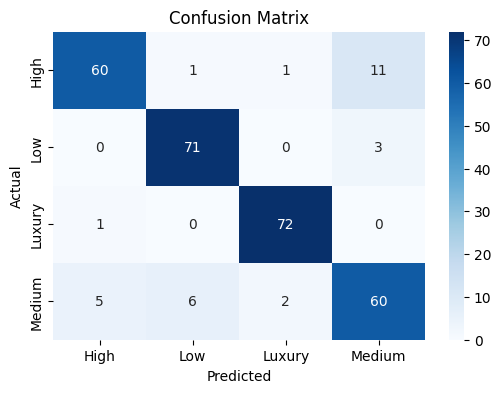

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Building Recommendation System

### Tf-idf Vectorization 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Merge content columns
dataset["content"] = (
    dataset["product_name"]+ " " +
    dataset["category"] + " " +
    dataset["about_product"]
)

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(dataset["content"])

# Tính cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Hàm gợi ý theo content
indices = pd.Series(dataset.index, index=dataset["product_id"]).drop_duplicates()


In [35]:
def recommend_content_based(product_id, top_n=5):
    if product_id not in indices:
        return []
    idx = indices[product_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    product_indices = [i[0] for i in sim_scores]
    return dataset.iloc[product_indices][["product_id", "product_name", "category", "product_link"]]

### Collaborative Filtering 

In [21]:
# Installing the surprise
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2618942 sha256=1759136715f2aac4d05991e91b76b472999e086b135ac9b69e663f50aa3d5978
  Stored in directory: /home/dikhangcshcmut/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [37]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Tạo user-item matrix
ratings = dataset[["user_id", "product_id", "rating"]].dropna()
user_item_matrix = ratings.pivot_table(index="user_id", columns="product_id", values="rating").fillna(0)

# Tính similarity giữa các items (dựa trên vector user-rating)
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# CF recommend (item-based)
def recommend_collaborative(user_id, top_n=5):
    if user_id not in user_item_matrix.index:
        return []

    user_ratings = user_item_matrix.loc[user_id]
    scores = {}

    # Duyệt qua các item mà user đã rated
    for item, rating in user_ratings[user_ratings > 0].items():
        similar_items = item_similarity_df[item].drop(item)
        for sim_item, sim_score in similar_items.items():
            if user_ratings[sim_item] == 0:  # chưa rated
                scores[sim_item] = scores.get(sim_item, 0) + sim_score * rating

    # Lấy top_n
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    product_ids = [iid for iid, _ in sorted_scores]
    
    return dataset[dataset["product_id"].isin(product_ids)][["product_id", "product_name", "category", "product_link"]]


# Combine to hybrid recommendation system

In [38]:
def recommend_hybrid(user_id, product_id, top_n=5, alpha=0.5):
    if product_id not in indices or user_id not in user_item_matrix.index:
        return []

    # Content-based similarity
    idx = indices[product_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:50]  # lấy 50 sp tương tự
    
    hybrid_scores = []
    for i, sim in sim_scores:
        iid = dataset.iloc[i]["product_id"]

        # CF score: similarity trung bình với sp user đã rating
        user_ratings = user_item_matrix.loc[user_id]
        cf_score = 0
        if iid in item_similarity_df.columns:
            for rated_item, rating in user_ratings[user_ratings > 0].items():
                cf_score += item_similarity_df.loc[iid, rated_item] * rating

        hybrid_score = alpha * sim + (1 - alpha) * cf_score
        hybrid_scores.append((iid, hybrid_score))

    # Top N
    hybrid_scores = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)[:top_n]
    product_ids = [iid for iid, _ in hybrid_scores]
    
    return dataset[dataset["product_id"].isin(product_ids)][["product_id", "product_name", "category", "product_link"]]
